In [11]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import pymongo

In [12]:
#connect to the database MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["Amazon"]
mycol = mydb["amazon_beauty"]

In [13]:
#read dataset from mongoDB into dataframe
df = pd.DataFrame(list(mycol.find()))

In [14]:
df.head()

,_id,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,611e6656728b844b7554f08d,US,1797882,R3I2DHQBR577SS,B001ANOOOE,2102612,The Naked Bee Vitmin C Moisturizing Sunscreen ...,Beauty,5.0,0.0,0.0,N,Y,Five Stars,"Love this, excellent sun block!!",1970-01-01
1,611e6656728b844b7554f08e,US,18381298,R1QNE9NQFJC2Y4,B0016J22EQ,106393691,"Alba Botanica Sunless Tanning Lotion, 4 Ounce",Beauty,5.0,0.0,0.0,N,Y,Thank you Alba Bontanica!,The great thing about this cream is that it do...,1970-01-01
2,611e6656728b844b7554f08f,US,19242472,R3LIDG2Q4LJBAO,B00HU6UQAG,375449471,"Elysee Infusion Skin Therapy Elixir, 2oz.",Beauty,5.0,0.0,0.0,N,Y,Five Stars,"Great Product, I'm 65 years old and this is al...",1970-01-01
3,611e6656728b844b7554f090,US,19551372,R3KSZHPAEVPEAL,B002HWS7RM,255651889,"Diane D722 Color, Perm And Conditioner Process...",Beauty,5.0,0.0,0.0,N,Y,GOOD DEAL!,I use them as shower caps & conditioning caps....,1970-01-01
4,611e6656728b844b7554f091,US,14802407,RAI2OIG50KZ43,B00SM99KWU,116158747,Biore UV Aqua Rich Watery Essence SPF50+/PA+++...,Beauty,5.0,0.0,0.0,N,Y,this soaks in quick and provides a nice base f...,This is my go-to daily sunblock. It leaves no ...,1970-01-01


In [15]:
df = df[['_id', 'product_id', 'review_headline', 'star_rating']]
df.head()

,_id,product_id,review_headline,star_rating
0,611e6656728b844b7554f08d,B001ANOOOE,Five Stars,5.0
1,611e6656728b844b7554f08e,B0016J22EQ,Thank you Alba Bontanica!,5.0
2,611e6656728b844b7554f08f,B00HU6UQAG,Five Stars,5.0
3,611e6656728b844b7554f090,B002HWS7RM,GOOD DEAL!,5.0
4,611e6656728b844b7554f091,B00SM99KWU,this soaks in quick and provides a nice base f...,5.0


In [16]:
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   _id              1048575 non-null  object 
 1   product_id       1048575 non-null  object 
 2   review_headline  1048483 non-null  object 
 3   star_rating      1048486 non-null  float64
dtypes: float64(1), object(3)
memory usage: 32.0+ MB

Missing values:   181


_id                 0
product_id          0
review_headline    92
star_rating        89
dtype: int64

In [17]:
#remove missing values NaN
df = df.dropna()

In [18]:
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048483 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   _id              1048483 non-null  object 
 1   product_id       1048483 non-null  object 
 2   review_headline  1048483 non-null  object 
 3   star_rating      1048483 non-null  float64
dtypes: float64(1), object(3)
memory usage: 40.0+ MB

Missing values:   0


_id                0
product_id         0
review_headline    0
star_rating        0
dtype: int64

In [19]:
#to remove row where star_rating = 3
df = df.loc[df["star_rating"] != 3]

In [20]:
df["sentiment"] = df["star_rating"].apply(lambda score: "positive" if score > 3 else "negative")

In [21]:
df.sentiment.value_counts()

positive    830541
negative    140633
Name: sentiment, dtype: int64

In [22]:
df.head()

,_id,product_id,review_headline,star_rating,sentiment
0,611e6656728b844b7554f08d,B001ANOOOE,Five Stars,5.0,positive
1,611e6656728b844b7554f08e,B0016J22EQ,Thank you Alba Bontanica!,5.0,positive
2,611e6656728b844b7554f08f,B00HU6UQAG,Five Stars,5.0,positive
3,611e6656728b844b7554f090,B002HWS7RM,GOOD DEAL!,5.0,positive
4,611e6656728b844b7554f091,B00SM99KWU,this soaks in quick and provides a nice base f...,5.0,positive


In [23]:
regEx = re.compile('[^a-z]+')
def preprocessing(reviews):
    
    reviews = reviews.lower()                                             # Lowercases the string
    reviews = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', reviews)   # Remove URLs
    reviews = re.sub(r"\d+", " ", str(reviews))                           # Removes all digits
    reviews = re.sub(r"[^\w\s]", " ", str(reviews))                       # Removes all punctuations
    reviews = re.sub(r"\s+", " ", str(reviews))                           # Replaces double spaces with single space
    reviews = regEx.sub(' ', reviews).strip()
    
    return reviews

df["review_clean"] = df["review_headline"].apply(preprocessing)
df.head()

,_id,product_id,review_headline,star_rating,sentiment,review_clean
0,611e6656728b844b7554f08d,B001ANOOOE,Five Stars,5.0,positive,five stars
1,611e6656728b844b7554f08e,B0016J22EQ,Thank you Alba Bontanica!,5.0,positive,thank you alba bontanica
2,611e6656728b844b7554f08f,B00HU6UQAG,Five Stars,5.0,positive,five stars
3,611e6656728b844b7554f090,B002HWS7RM,GOOD DEAL!,5.0,positive,good deal
4,611e6656728b844b7554f091,B00SM99KWU,this soaks in quick and provides a nice base f...,5.0,positive,this soaks in quick and provides a nice base f...


In [24]:
train, test = train_test_split(df, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

776939 items in training data, 194235 in test data


In [25]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 2))
X_train_counts = countVector.fit_transform(train["review_clean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["review_clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

In [26]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=countVector.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
stars,2.091997
five,2.306438
five stars,2.307313
great,3.300168
it,3.332781
...,...
be shortened,13.869971
ladies saw,13.869971
ladies save,13.869971
ladies that,13.869971


# Multinomial Naive Bayes Training and Testing

In [27]:
multinomial = MultinomialNB()
multinomial_result = multinomial.fit(X_train_tfidf, y_train)
prediction['Multinomial'] = multinomial.predict(X_test_tfidf)

In [28]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.96      0.63      0.76     28057
    negative       0.94      1.00      0.97    166178

    accuracy                           0.94    194235
   macro avg       0.95      0.81      0.87    194235
weighted avg       0.94      0.94      0.94    194235



In [29]:
accuracy_score(y_test, prediction['Multinomial'])

0.9432748989625969

Confusion matrix : 
 [[ 17712  10345]
 [   673 165505]]


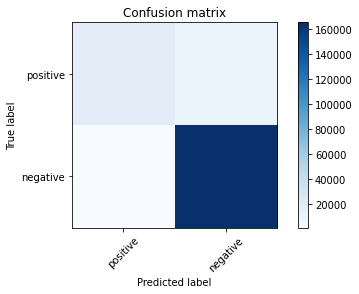

In [30]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)  
print('Confusion matrix : \n',matrix)

# Bernoulli Naive Bayes Training and Testing

In [31]:
bernoulli = BernoulliNB()
bernoulli_result = bernoulli.fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = bernoulli.predict(X_test_tfidf)

In [32]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.76      0.75      0.75     28057
    negative       0.96      0.96      0.96    166178

    accuracy                           0.93    194235
   macro avg       0.86      0.85      0.86    194235
weighted avg       0.93      0.93      0.93    194235



In [33]:
accuracy_score(y_test, prediction['Bernoulli'])

0.9299920199758025

Confusion matrix : 
 [[ 20931   7126]
 [  6472 159706]]


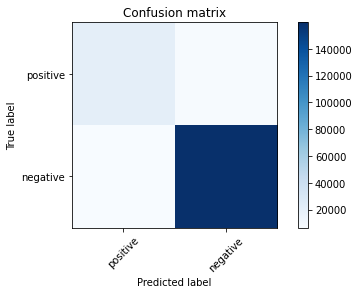

In [34]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Bernoulli'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    
print('Confusion matrix : \n',matrix)

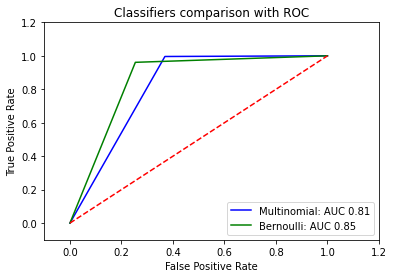

In [35]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Testing using Multinomial Naive Bayes Model

In [36]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(multinomial, " I LOVE this mascara")
testSentiments(multinomial, "AMAZING VOLUME!")
testSentiments(multinomial, "Mascara is bad and runs resulting in Horrible raccoon eyes.")

Sample estimated as POSITIVE: negative prob 0.002758, positive prob 0.997242
Sample estimated as POSITIVE: negative prob 0.007576, positive prob 0.992424
Sample estimated as NEGATIVE: negative prob 0.769565, positive prob 0.230435


In [37]:
test['predict'] = prediction['Multinomial']

C:\Users\HP\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test.head()

,_id,product_id,review_headline,star_rating,sentiment,review_clean,predict
35821,611e6659728b844b75557c7a,B006UET4XE,Four Stars,4.0,positive,four stars,positive
967944,611e66a3728b844b7563b595,B00TJ0CQZE,He followed the easy to understand instructions,5.0,positive,he followed the easy to understand instructions,positive
116679,611e665f728b844b7556b854,B006GQYSC8,Four Stars,4.0,positive,four stars,positive
436602,611e667a728b844b755b9a07,B00HQ2RB34,Five Stars,5.0,positive,five stars,positive
881312,611e669c728b844b7562632d,B00LLMB3W0,Great product for lashes others will notice.,5.0,positive,great product for lashes others will notice,positive


In [39]:
test.predict.value_counts()

positive    175850
negative     18385
Name: predict, dtype: int64

In [40]:
test.product_id.value_counts()

B001MA0QY2    637
B0049LUI9O    287
B00DPE9EQO    228
B00016XJ4M    227
B00SMIIR0W    219
             ... 
B00HRG544M      1
B0001D6KXC      1
B00M0S96Z0      1
B00S6XI6H2      1
B00J4QH7DO      1
Name: product_id, Length: 81217, dtype: int64

In [41]:
sentiment_count = test.groupby('predict').count()
sentiment_sum = sum(sentiment_count.review_clean)
sentiment_count.review_clean = (sentiment_count*100/sentiment_sum).round(2)
sentiment_count.review_clean

predict
negative     9.47
positive    90.53
Name: review_clean, dtype: float64

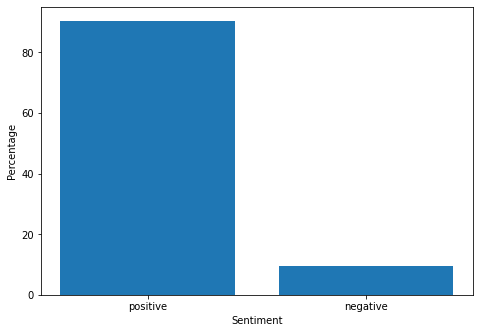

In [42]:
sentiment = ['positive', 'negative']
percentage = [90.54, 9.46]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sentiment,percentage)
plt.ylabel('Percentage')
plt.xlabel('Sentiment')
plt.show()

In [43]:
#test.to_csv('multitesting_dataset.csv')